## Binary Search Tree

How does a search tree work? What are its properties?

In [4]:
# Toy dataset

towns = {
    0: {'name': 'Romanshorn', 'population': 11000, 'latitude': 47.56586, 'longitude': 9.37869},
    1: {'name': 'Amriswil', 'population': 14000, 'latitude': 47.54814, 'longitude': 9.30327},
    2: {'name': 'Arbon', 'population': 12000, 'latitude': 47.51360, 'longitude': 9.42999},
    3: {'name': 'Weinfelden', 'population': 13000, 'latitude': 47.56638, 'longitude': 9.10588},
    4: {'name': 'Frauenfeld', 'population': 25000, 'latitude': 47.55856, 'longitude': 8.89685},
}

### BST Nodes
A binary node with two children, a key, and a value (payload).

In [5]:
class BstNode():
    """Invariant: All keys in left subtree are <= key, all keys in right subtree are >= key."""
    def __init__(self, key, value):
        self.left = None
        self.right = None
        self.key = key
        self.value = value

In [22]:
# Lets sort the tuples
sorted_by_population = []
for id,town in towns.items():
    tuple_population_id = (town['population'], id)
    sorted_by_population.append(tuple_population_id)


sorted_by_population.sort()
sorted_by_population

[(11000, 0), (12000, 2), (13000, 3), (14000, 1), (25000, 4)]

### Building a Tree

Use the list of elements sorted by the search dimension - always use the median of the remaining list as the next node. Build the tree recursively.

In [25]:
def build_bst(sorted_tuples, lower, upper):
    """Include all elements in sorted_tuples from lower to upper indices (inclusive)."""
    if lower > upper:
        return None
    median_index = (lower + upper) // 2
    median_element = sorted_tuples[median_index]
    node = BstNode(median_element[0], median_element[1])
    node.left = build_bst(sorted_tuples, lower, median_index - 1)
    node.right = build_bst(sorted_tuples, median_index + 1, upper)
    return node

tree = build_bst(sorted_by_population, 0, len(sorted_by_population)-1)

In [26]:
def walk_tree(tree):
    if tree is None:
        return
    yield from walk_tree(tree.left)
    yield tree.key
    yield from walk_tree(tree.right)

for key in walk_tree(tree): print(key)

11000
12000
13000
14000
25000



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


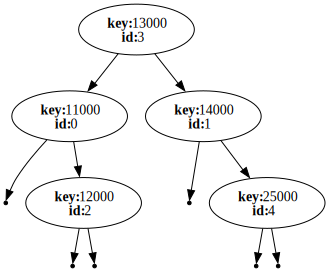

In [40]:
%pip install graphviz
import graphviz

def render_tree(graph, node, nuller=""):
    if node is None:
        graph.node(nuller, "", shape="point")
        return nuller
    id = str(node.key)
    graph.node(id, f"< <B>key:</B> {id}<BR/><B>id:</B> {str(node.value)} >")
    left_key = render_tree(graph, node.left, nuller + "l")
    graph.edge(id, left_key)
    right_key = render_tree(graph, node.right, nuller + "r")
    graph.edge(id, right_key)
    return id

dot = graphviz.Digraph()
render_tree(dot, tree)
dot